In [1]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
headlines = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json',
                         lines = True)

In [3]:
headlines.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

Let's just make sure that the observations corresponding to the two labels (**is_sarcastic = 0, 1** are balanced. We see that there are 14,985 of headlines that have been identified as not sarcastic and 13,634 of headlines that have been identified as sarcastic. We are going to keep these observations as they are. 

In [4]:
headlines.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

## Split Data into Train and Validation Data

In [5]:
train_df, val_df, test_df = np.split(headlines.sample(frac = 1), 
                                     [int(0.7 * len(headlines)), int(0.85 * len(headlines))])

In [6]:
print("Number of observations in training data set: {}".format(len(train_df)))
print("Number of observations in validation data set: {}".format(len(val_df)))
print("Number of observations in test data set: {}".format(len(test_df)))

Number of observations in training data set: 20033
Number of observations in validation data set: 4293
Number of observations in test data set: 4293


In [7]:
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.headline, train_df.is_sarcastic)).shuffle(len(train_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df.headline, val_df.is_sarcastic)).shuffle(len(val_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.headline, test_df.is_sarcastic)).shuffle(len(test_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## BERT-based Classifier

Here, we are going to use a BERT model that has been pre-trained on English Wikipedia and BooksCorpus datasets. To start things off, we are going to use the **wiki_books** model. In subsequent iterations, we are going to use models that have been fine-tuned for other purposes such as sentiment analysis ... etc. Find out more about the models [here](https://tfhub.dev/google/collections/experts/bert/1).

In [8]:
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2"
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [9]:
preprocess_layer = hub.KerasLayer(PREPROCESS_MODEL)
bert_layer = hub.KerasLayer(BERT_MODEL)

In [10]:
input_layer = tf.keras.Input(shape = (), dtype = tf.string)
encoder_input = preprocess_layer(input_layer)
encoder_output = bert_layer(encoder_input)

output = tf.keras.layers.Dropout(0.3)(encoder_output['pooled_output'])
output = tf.keras.layers.Dense(64, activation = 'relu')(output)
output = tf.keras.layers.Dropout(0.3)(output)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(output)

model = tf.keras.Model(inputs = [input_layer], outputs = output)
model.compile(optimizer = tf.keras.optimizers.AdamW(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [12]:
history = model.fit(train_dataset, 
                    validation_data = val_dataset,
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.6057
Epoch 1: val_loss improved from inf to 0.57955, saving model to model/best_performed_model.ckpt
79/79 [==============================] - 464s 6s/step - loss: 0.6630 - accuracy: 0.6057 - val_loss: 0.5795 - val_accuracy: 0.7130
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.6797
Epoch 2: val_loss improved from 0.57955 to 0.54107, saving model to model/best_performed_model.ckpt
79/79 [==============================] - 452s 6s/step - loss: 0.5940 - accuracy: 0.6797 - val_loss: 0.5411 - val_accuracy: 0.7398
Epoch 3/30
79/79 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.7013
Epoch 3: val_loss improved from 0.54107 to 0.50941, saving model to model/best_performed_model.ckpt
79/79 [==============================] - 449s 6s/step - loss: 0.5695 - accuracy: 0.7013 - val_loss: 0.5094 - val_accuracy: 0.7671
Epoch 4/30
79/79 [==============

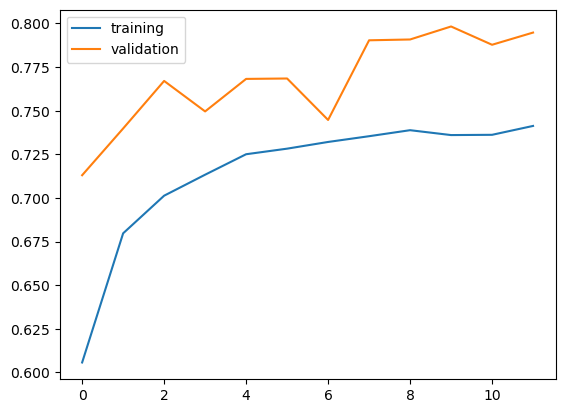

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

## Test the Model

In [20]:
model.evaluate(test_dataset)

17/17 [==============================] - 79s 5s/step - loss: 0.4648 - accuracy: 0.7939


[0.46481049060821533, 0.7938504815101624]

The model performs pretty moderately well with **79.39%** test accuracy. Hopefully we can achieve better test accuracy with more sophisticated models. 